In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow
from adjustText import adjust_text
from sklearn.metrics import pairwise_distances

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_ref = os.path.join(pth_data, 'figures')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attributions')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# average latent z, module attributions (training celltypes only)
src_train = df.loc[df.Training == True].index
msk = adata.obs.source.isin(src_train) & (adata.obs.trajectory == 'True')
grp = adata[msk].obs.groupby(['source', 'celltype'], observed = True)
z = grp.latent_z.mean().sort_values(ascending = False).loc[grp.size() > 200]
attr = grp[src_train].mean().loc[z.index]
z.to_csv(os.path.join(pth_ref, 'latent_z.csv'))
attr.to_csv(os.path.join(pth_ref, 'attributions.csv'))

In [6]:
# PCA decomposition (module attributions)
pca = PCA(n_components = 2).fit(attr)
attr_pca = pd.DataFrame(pca.fit_transform(attr),
                        index = attr.index,
                        columns = ['PC1', 'PC2'])

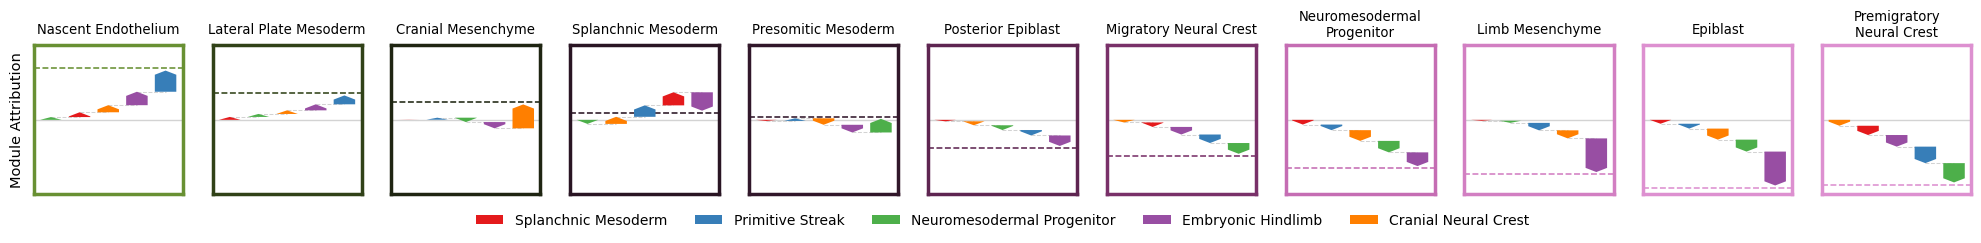

In [7]:
# waterfall plots
wbar, pad, cmap = .75, [.6, .075], plt.cm.Set1
colors = {col : cmap(i) for i, col in enumerate(attr.columns)}
xlim = (-pad[0], attr.shape[1] - 1 + pad[0])
ylim = attr.sum(axis = 1).abs().max() + pad[1]

# plot grid
fs, cmap_z = 9.5, plt.cm.vanimo
fig, ax = plt.subplots(1, attr.shape[0], figsize = (25, 5))
for i, ix in enumerate(attr.index):
    attr_i = attr.loc[ix].sort_values(key = abs)
    heads = attr_i.cumsum().to_numpy()
    tails = np.concat(([0], heads[:-1]))
    colors_i = attr_i.index.map(colors)
    color_zi = cmap_z(z.loc[ix])
  
    # plot bars
    for j in range(heads.size):
        dy = heads[j] - tails[j]
        head_length = min(abs(dy), .035)
        arrow = FancyArrow(
            x = j,
            y = tails[j],
            dx = 0,
            dy = dy,
            width = wbar,
            head_width = wbar,
            head_length = head_length,
            length_includes_head = True,
            linewidth = 0,
            color = colors_i[j])
        ax[i].add_artist(arrow)

        # connection
        if j > 0:
            ax[i].plot(
                [j - 1, j],
                [heads[j - 1], tails[j]],
                c = 'lightgray',
                linestyle = '--',
                linewidth = .75,
                zorder = 0)

    # zero attribution
    ax[i].axhline(0,
                  color = 'lightgray',
                  linewidth = 1,
                  zorder = 0)
    
    # total attribution
    offset = np.sign(dy) * .0185
    ax[i].axhline(heads[j] + offset,
                  color = color_zi,
                  linestyle = '--',
                  linewidth = 1.15,
                  zorder = 0)
    
    # average score
    for sp in ax[i].spines.values():
        sp.set_color(color_zi)
        sp.set_linewidth(2.5)

    ax[i].set_title(ix[1], size = fs, pad = 8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(-ylim, ylim)
    ax[i].set_box_aspect(1)

for i in (7, 10):
    title = ax[i].get_title().replace(' ', '\n', 1)
    ax[i].set_title(title, size = fs)

ax[0].set_ylabel('Module Attribution',
                 size = 10.5,
                 labelpad = 7)

# legend
handles = [Patch(facecolor = val, label = df.loc[key].Name)
           for key, val in colors.items()]
ax[5].legend(handles = handles,
             loc = 'center',
             fontsize = 10,
             frameon = False,
             ncol = len(handles),
             bbox_to_anchor = (.5, -.175))

fn = os.path.join(pth_out, 'waterfall.pdf')
plt.savefig(fn, bbox_inches = 'tight')

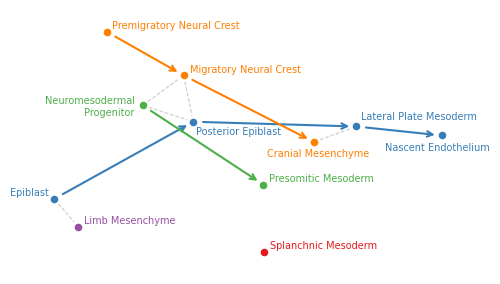

In [ ]:
arrowprops = {
    'arrowstyle' : '->',
    'linewidth'  : 1.5,
    'shrinkA'    : 7,
    'shrinkB'    : 5}

# plot attribution embedding
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
labels, objects = [], []
for src in src_train:
    X_src = attr_pca.loc[src]
    c = colors[src]
    arrowprops['color'] = c
    for i in range(X_src.shape[0]):
        coords = X_src.iloc[i]
        ax.scatter(*coords, s = 20, color = c)
        labels.append(
            ax.text(*coords,
                    X_src.index[i],
                    size = 7,
                    color = c,
                    zorder = 100))
        if i > 0:
            coords_prev = X_src.iloc[i - 1]
            ax.annotate('', coords_prev, coords,
                        arrowprops = arrowprops)

arrowprops = {
    'arrowstyle' : '-',
    'linestyle'  : (0, (2, 2)),
    'color'      : 'lightgray',
    'linewidth'  : 1,
    'shrinkA'    : 5,
    'shrinkB'    : 5}

# annotate celltype clusters
D = pairwise_distances(attr_pca)
D[np.tril_indices(D.shape[0])] = np.nan
ix, jx = np.where(D < .075)
for i in range(ix.size):
    coords0 = attr_pca.iloc[ix[i]]
    coords1 = attr_pca.iloc[jx[i]]
    objects.append(
        ax.annotate('', coords0, coords1,
                    arrowprops = arrowprops))

# adjust labels
plt.margins(.4, .4)
adjust_text(labels, add_objects = objects)
plt.margins(.1, .1)

label_dict = {
    'Neuromesodermal Progenitor' : 'Neuromesodermal\nProgenitor'}

pos_dict = {
    'Epiblast'                   : (-.005, 0),
    'Posterior Epiblast'         : (.005, -.0075),
    'Lateral Plate Mesoderm'     : (0, .005),
    'Nascent Endothelium'        : (.01, 0),
    'Migratory Neural Crest'     : (.155, 0),
    'Cranial Mesenchyme'         : (.075, -.0075),
    'Neuromesodermal Progenitor' : (-.0035, -.01),
    'Presomitic Mesoderm'        : (.0025, 0),
    'Limb Mesenchyme'            : (.0035, 0),
    'Splanchnic Mesoderm'        : (.0025, 0)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_aspect(1); ax.axis(False)
fn = os.path.join(pth_out, 'embedding.pdf')
plt.savefig(fn, bbox_inches = 'tight')

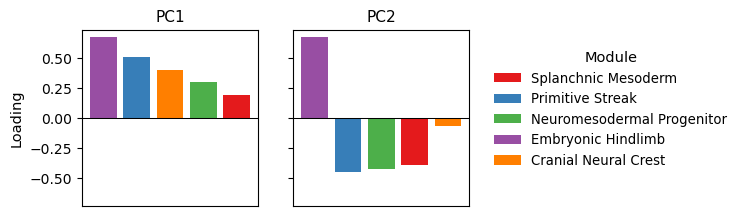

In [108]:
# plot component loadings
fig, ax = plt.subplots(1, 2, figsize = (5, 2.5), sharey = True)
xx = np.arange(attr.shape[1])
for i in range(2):
    height = pca.components_[i]
    order = abs(height).argsort()[::-1]
    height = height[order]
    color = attr.columns[order].map(colors)
    ax[i].bar(xx, height, color = color)
    ax[i].axhline(0,
                  color = 'k',
                  linewidth = .75,
                  zorder = 100)
    ax[i].set_title(f'PC{i + 1}', size = 11)
    ax[i].set_xticks([])
    ax[i].set_box_aspect(1)

ylim = max(ax[0].get_ylim())
for i in range(2):
    ax[i].set_ylim(-ylim, ylim)

ax[0].set_ylabel('Loading', size = 10.5)
ax[1].legend(handles = handles,
             title = 'Module',
             fontsize = 9.5,
             title_fontsize = 10.5,
             loc = 'center left',
             bbox_to_anchor = (1.075, .55),
             frameon = False)

fn = os.path.join(pth_out, 'loadings.pdf')
plt.savefig(fn, bbox_inches = 'tight')